In [1]:
import requests      
from datetime import datetime
from bs4 import BeautifulSoup  
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
import re, csv, string 
import gensim
import pandas as pd
from gensim import corpora, models
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np


#------------------------------------------------HELPER FUNCTIONS---------------------------------------------------------
## Separates headlines out from 'all_data' variable so it can be written to separate columns in csv
def get_headline_list(filtered_data, index):
    headlines_list = []
    for row in filtered_data:
        headlines_list.append(row[index])
    return headlines_list

## Separate dates out from 'all_data' variable so it can be written to separate columns in csv
def get_date_list(filtered_data, index):
    date_list = []
    for row in filtered_data:
        date_list.append(row[index])
    return date_list

## Handle cleaning of one specific date format
def tokenize_date(s):
    pattern=r'[a-zA-Z{3}]+[.\s]+[\d{1,2}\,\s]+[\d{4}]+'                        
    tokens=nltk.regexp_tokenize(s, pattern)
    date = tokens
    return date


#--------------------------------------------------WEB SCRAPERS---------------------------------------------------------
def get_bloomberg_headlines():
    headlines=[]  # list variable to store headlines
    dates = []    # list variable to store dates
    raw_headlines = [] 
    page_number = 1
    page_url="https://www.bloomberg.com/search?query=bitcoin&sort=time:desc&endTime=2018-04-27T17:35:17.135Z&page="+str(page_number)
    # loop until page 80
    while page_url!="https://www.bloomberg.com/search?query=bitcoin&sort=time:desc&endTime=2018-04-27T17:35:17.135Z&page=80":     
        page_url="https://www.bloomberg.com/search?query=bitcoin&sort=time:desc&endTime=2018-04-27T17:35:17.135Z&page="+str(page_number)
        page = requests.get(page_url) 
        page_number += 1
        if page_number % 20 == 0:
            print('scraped %s of 80 pages' % page_number)
        if page.status_code!=200:  
            page_number = 80 #if page status code fails to equal 200, connection failed; set page_num to while loop condition
        else:                   
            soup = BeautifulSoup(page.content, 'html.parser')                        
            
#-----------scrape and clean all headlines and append to a list called headlines----------------------------------------------
            for header in soup.find_all('h1', class_ ='search-result-story__headline'):
                headline = header.get_text().lower()
                raw_headlines.append(headline)
                
#-----------scrape all dates and append to a list called dates---------------------------------------------------------------
            for date in soup.find_all('time', class_ = 'published-at'):
                date_published = date.get_text()
                date_published = date_published.lstrip()
                dates.append(date_published)
                 
#---join headlines list and dates list into a list of tuples called raw_data-----------------------------------------------------
    raw_data = zip(raw_headlines, dates)
    
    return raw_data

def coindesk_market_parser():
    headlines=[]
    page_url= "https://www.coindesk.com/category/markets-news/markets-markets-news/markets-bitcoin/"
    while page_url!=None:
        page = requests.get(page_url) 
        if page.status_code!=200:
             page_url=None
        else:
            all_data = []
            all_data_raw = []
            raw_headlines = []
            for num in range(1,50):
                if num % 5 == 0:
                    print('scraped %s of 50 pages' % num)
                page_url = "https://www.coindesk.com/category/markets-news/markets-markets-news/markets-bitcoin/page/"+str(num)+"/"
                page = requests.get(page_url)
                soup = BeautifulSoup(page.content, "html.parser")
                titles = soup.find_all("a", class_ = "fade")
                titles_dictionary = []
                for i in titles:
                    title = i.get_text().lower()
                    raw_headlines.append(title)
                dates = soup.find_all("time")
                dates_list = []
                for i in dates:
                    date = i.get_text().lower()
                    date = date.replace(' at', '')
                    date = datetime.strptime(date, '%b %d, %Y %H:%M')
                    date = datetime.strftime(date,'%b %d, %Y')
                    dates_list.append(date)
                raw_data = zip(raw_headlines, dates_list)
        page_url = None
    return raw_data

def coindesk_parser():    
    headlines=[]
    page_url= "https://www.coindesk.com/category/technology-news/bitcoin/"
    while page_url!=None:
        page = requests.get(page_url) 
        if page.status_code!=200:
             page_url=None
        else:
            all_data = []
            all_data_raw = []
            raw_headlines = []
            for num in range(1,50):
                if num % 5 == 0:
                    print('scraped %s of 50 pages' % num)
                page_url = "https://www.coindesk.com/category/technology-news/bitcoin/page/"+str(num)+"/"
                page = requests.get(page_url)
                soup = BeautifulSoup(page.content, "html.parser")
                titles = soup.find_all("a", class_ = "fade")
                titles_dictionary = []
                for i in titles:
                    title = i.get_text().lower()
                    raw_headlines.append(title)
                dates = soup.find_all("time")
                dates_list = []
                for i in dates:
                    date = i.get_text().lower()
                    date = date.replace(' at', '')
                    date = datetime.strptime(date, '%b %d, %Y %H:%M')
                    date = datetime.strftime(date,'%b %d, %Y')
                    dates_list.append(date)
                raw_data = zip(raw_headlines, dates_list)
        page_url = None
    return raw_data


def marketwatch_parser():
    headlines=[]
    page_url= "https://www.marketwatch.com/search?q=bitcoin&m=Keyword&rpp=500&mp=806&bd=false&bdv=&rs=false"
    while page_url!=None:
        page = requests.get(page_url) 
        if page.status_code!=200:
             page_url=None
        else:
            all_data = []
            all_data_raw = []
            page_url = "https://www.marketwatch.com/search?q=bitcoin&m=Keyword&rpp=500&mp=806&bd=false&bdv=&rs=false"
            page = requests.get(page_url)
            soup = BeautifulSoup(page.content, "html.parser")
            divs = soup.find_all("div", class_ = "searchresult")
            titles_dictionary = []
            raw_headlines = []
            for idx, div in enumerate(divs):
                titles = div.select("a")
                if titles != []:
                    title = titles[0].get_text()
                    raw_headlines.append(title)
            divs_dates = soup.find_all("div", class_ = "deemphasized")
            dates_list = []
            for idx, div in enumerate(divs_dates):
                date = div.get_text().lower()
                date = str(tokenize_date(date)[0])
                date = datetime.strptime(date.replace("sept.","sep.").replace("july", "jul.").replace("june", "jun.").replace("may", "may.").replace("march", "mar.").replace("april", "apr."), '%b. %d, %Y')
                date = datetime.strftime(date,'%b %d, %Y')
                dates_list.append(date)
            raw_data = zip(raw_headlines, dates_list)
        page_url = None
    return raw_data

def get_bitcoinNews_headlines():
    headlines=[]  # list variable to store headlines
    dates = []    # list variable to store date
    raw_headlines = []
    page_number = 1
    page_url="https://news.bitcoin.com/page/"+str(page_number)+"/?s=bitcoin"
    # page 140 as parameter
    while page_url!="https://news.bitcoin.com/page/140/?s=bitcoin":
        if page_number % 20 == 0:
            print('scraped %s of 140 pages' % page_number)
        page_url="https://news.bitcoin.com/page/"+str(page_number)+"/?s=bitcoin"        
        page = requests.get(page_url) 
        page_number += 1
        if page.status_code!=200:  
            page_number = None #if page status code fails to equal 200, connection failed; set page_num to while loop condition
        else:                   
            soup = BeautifulSoup(page.content, 'html.parser')                        
            
#-----------scrape and clean all headlines and append to a list called headlines----------------------------------------------
            main_content = soup.find('div', class_ = 'td-ss-main-content')            
            h3s = main_content.find_all('h3', class_ = "entry-title td-module-title")
            for idx, h3 in enumerate(h3s):
                header = h3.select('a')
                if header != []:
                    headline = header[0].get_text().lower()
                    raw_headlines.append(headline)
#-----------scrape all dates and append to a list called dates---------------------------------------------------------------
            span_dates = main_content.find_all("span", class_ = "td-post-date")
            for idx, span in enumerate(span_dates):
                dates_list = span.select('time')
                if dates_list != []:
                    date = dates_list[0].get_text()
                    dates.append(date)
    
#---join headlines list and dates list into a list of tuples called raw_data-----------------------------------------------------
    raw_data = zip(raw_headlines, dates)
    return raw_data

def get_wsj_headlines():
    f = open('wsj_data.txt', 'r',encoding='latin-1')
    lines = [line for line in f]  
    headline_info = []
    raw_headlines = []
    date_info = []
    left_side_info = []
    right_side_info = []
    
    for i in lines: 
        temp = i
        # filter out rows without keywords 'Wall Street Journal' and filter out rows with 'regulation newsletter'
        if ( temp.find("Wall Street Journal") !=-1 and temp.find("financial regulation newsletter") == -1):
            wsj_data = temp 
            date = re.findall(r'\d{4}[,]\s[a-zA-Z]+\s[\d]+', wsj_data)                              
            date_str = date[0]                                                # get the date as string format
            date_str = datetime.strptime(date_str, '%Y, %b %d')
            date_str = datetime.strftime(date_str,'%b %d, %Y')
            date_info.append(date_str)                                        # append the date into a list
            idx_r_p = wsj_data.find(")")                                      # get the index of right parenthesis
            idx_l_p = wsj_data.find("(")                                      # get the index of left parenthesis
            left_side_date = wsj_data[0:idx_l_p]                              # get the lefe part of date in each row
            left_side_info.append(left_side_date)                             # append it into a list 
            right_side_date = wsj_data[idx_r_p+3::]                           # get the right side of date in each row
            right_side_info.append(right_side_date)                           # append it into a list 
            idx_wsj = right_side_date.find("Wall Street Journal")             # get the index of 'Wall Street Journal' of right side of date

            if (idx_wsj == 0):
#               if 'Wall Street Journal' is at the beginning of right side of date, get the headline from the left side of date
                headline = left_side_date
                t_headline = headline.lower()
                raw_headlines.append(t_headline)
                
            else:
#          if 'Wall Street Journal' is not at the beginning of right side of date, get the headline between right parenthesis and Wall Street Journal        
                headline = right_side_date[0:idx_wsj]
                t_headline = headline.lower()     
                raw_headlines.append(t_headline)
            
            raw_data = zip(raw_headlines, date_info)
            
    return raw_data



if __name__ == "__main__":
    print("This web scraper takes about 10 minutes to run")
    print("scraping bloomberg data...")
    bloomberg_raw = get_bloomberg_headlines()
    print("scraping coindesk markets data...")
    coindesk_market_raw = coindesk_market_parser()
    print("scraping other coindesk data...")
    coindesk_raw = coindesk_parser()
    print("scraping marketwatch data...")
    marketwatch_raw = marketwatch_parser()
    print("scraping bitcoinNews data...")
    bitcoinNews_raw = get_bitcoinNews_headlines()
    print("scraping WSJ data from txt file...")
    wsj_raw = get_wsj_headlineswsj_raw = get_wsj_headlines()
    print("done scraping all data - stored in list 'all_data_raw' ")

    # All raw data with headlines that don't include keywords filtered out
    all_data_raw = []
    all_data_raw.extend(list(bloomberg_raw) + list(coindesk_market_raw) + list(coindesk_raw) + list(marketwatch_raw) + list(bitcoinNews_raw)+ list(wsj_raw))
    print(all_data_raw)

/Users/Christina/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


This web scraper takes about 10 minutes to run
scraping bloomberg data...
scraping coindesk markets data...
scraped 5 of 50 pages
scraped 10 of 50 pages
scraped 15 of 50 pages
scraped 20 of 50 pages
scraped 25 of 50 pages
scraped 30 of 50 pages
scraped 35 of 50 pages
scraped 40 of 50 pages
scraped 45 of 50 pages
scraping other coindesk data...
scraped 5 of 50 pages
scraped 10 of 50 pages
scraped 15 of 50 pages
scraped 20 of 50 pages
scraped 25 of 50 pages
scraped 30 of 50 pages
scraped 35 of 50 pages
scraped 40 of 50 pages
scraped 45 of 50 pages
scraping marketwatch data...
scraping bitcoinNews data...
scraped 20 of 140 pages
scraped 40 of 140 pages
scraped 60 of 140 pages
scraped 80 of 140 pages
scraped 100 of 140 pages
scraped 120 of 140 pages
scraped 140 of 140 pages
scraping WSJ data from txt file...
done scraping all data - stored in list 'all_data_raw' 
[('the 17 millionth bitcoin is about to be mined: what it means and why it matters', 'Feb 17, 2015'), ('cisco claims new patent 

In [2]:
df = pd.DataFrame(all_data_raw)
df

,0,1
0,the 17 millionth bitcoin is about to be mined:...,"Feb 17, 2015"
1,cisco claims new patent could apply to bitcoin...,"Feb 13, 2015"
2,td ameritrade put an actual ad on the bitcoin ...,"Feb 13, 2015"
3,lightning + nfc? the new plan to bring bitcoin...,"Feb 11, 2015"
4,bitcoin dust: what it is and why you should ge...,"Feb 08, 2015"
5,'bitcoin day' proves crypto is thriving in arg...,"Feb 06, 2015"
6,why bitcoin lightning visualizers aren't quite...,"Feb 05, 2015"
7,mike hearn: bitcoin cash is repeating bitcoin'...,"Feb 04, 2015"
8,fed governor calls out crypto market 'volatility',"Feb 04, 2015"
9,lightning is being attacked for its own good,"Feb 03, 2015"


In [3]:
df.to_csv('web scrape.csv')
pd.read_csv('web scrape.csv')

,Unnamed: 0,0,1
0,0,the 17 millionth bitcoin is about to be mined:...,"Feb 17, 2015"
1,1,cisco claims new patent could apply to bitcoin...,"Feb 13, 2015"
2,2,td ameritrade put an actual ad on the bitcoin ...,"Feb 13, 2015"
3,3,lightning + nfc? the new plan to bring bitcoin...,"Feb 11, 2015"
4,4,bitcoin dust: what it is and why you should ge...,"Feb 08, 2015"
5,5,'bitcoin day' proves crypto is thriving in arg...,"Feb 06, 2015"
6,6,why bitcoin lightning visualizers aren't quite...,"Feb 05, 2015"
7,7,mike hearn: bitcoin cash is repeating bitcoin'...,"Feb 04, 2015"
8,8,fed governor calls out crypto market 'volatility',"Feb 04, 2015"
9,9,lightning is being attacked for its own good,"Feb 03, 2015"


In [4]:
# f = open('web scrape', encoding="latin-1")

In [8]:
# Initialize Sentiment Analyzer 
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [9]:
#Filter out headlines without these keywords
keywords = ['bitcoin', 'bitcoins', 'cryptocurrency','cryptocurrencies', 'crypto', 'blockchain', 'blockchains']
#get headlines and dates as individual lists
headlines = get_headline_list(list(filter(lambda x: any(word in x[0] for word in keywords), all_data_raw)),0)
dates = get_date_list(list(filter(lambda x: any(word in x[0] for word in keywords), all_data_raw)),1)

In [10]:
compounds = []
for row in headlines:
    row_lower = row.lower()
#     print(row_lower)
    ss = analyzer.polarity_scores(row_lower)
#     for k in sorted(ss):
#         print('{0}: {1}, '.format(k, ss[k]))
    compounds.append(ss['compound'])

#Count the number of headlines in each sentiment class
neutral = []
somewhat_negative = []
somewhat_positive = []
very_negative = []
very_positive = []
for index, score in enumerate(compounds):
    if score > -0.20 and score < 0.20:
#         compounds[index] = "Neutral"
        neutral.append(score)
    elif score > -0.60 and score < -0.20:
#         compounds[index] = "Somewhat Negative"
        somewhat_negative.append(score)
    elif score > 0.20 and score < 0.60:
#         compounds[index] = "Somewhat Positive"   
        somewhat_positive.append(score)
    elif score <= -0.60:
#         compounds[index] = "Very Negative"
        very_negative.append(score)
    else:
#         compounds[index] = "Very Positive"
        very_positive.append(score)

print('Neutral headlines: ', len(neutral))
print('Somewhat negative headlines: ', len(somewhat_negative))
print("Very negative headlines: ", len(very_negative))
print('Somewhat positive headlines: ', len(somewhat_positive))
print("Very positive headlines: ", len(very_positive))
print('Total number of headlines: ', len(compounds))

data_with_sentiment = list(zip(dates, headlines, compounds))
print(data_with_sentiment)

Neutral headlines:  1028
Somewhat negative headlines:  259
Very negative headlines:  66
Somewhat positive headlines:  329
Very positive headlines:  67
Total number of headlines:  1749
[('Feb 17, 2015', 'the 17 millionth bitcoin is about to be mined: what it means and why it matters', 0.0258), ('Feb 13, 2015', 'cisco claims new patent could apply to bitcoin mining', 0.0), ('Feb 13, 2015', 'td ameritrade put an actual ad on the bitcoin blockchain', 0.0), ('Feb 11, 2015', 'lightning + nfc? the new plan to bring bitcoin to retail', -0.5719), ('Feb 08, 2015', 'bitcoin dust: what it is and why you should get rid of it', 0.0), ('Feb 06, 2015', "'bitcoin day' proves crypto is thriving in argentina", 0.0), ('Feb 05, 2015', "why bitcoin lightning visualizers aren't quite what they seem", 0.0), ('Feb 04, 2015', "mike hearn: bitcoin cash is repeating bitcoin's mistakes", -0.3612), ('Feb 04, 2015', "fed governor calls out crypto market 'volatility'", 0.0), ('Apr 26, 2018', 'Have bitcoin investors b

In [16]:
data_with_sentiment_df=pd.DataFrame(data_with_sentiment)
data_with_sentiment_df

,0,1,2
0,"Feb 17, 2015",the 17 millionth bitcoin is about to be mined:...,0.0258
1,"Feb 13, 2015",cisco claims new patent could apply to bitcoin...,0.0000
2,"Feb 13, 2015",td ameritrade put an actual ad on the bitcoin ...,0.0000
3,"Feb 11, 2015",lightning + nfc? the new plan to bring bitcoin...,-0.5719
4,"Feb 08, 2015",bitcoin dust: what it is and why you should ge...,0.0000
5,"Feb 06, 2015",'bitcoin day' proves crypto is thriving in arg...,0.0000
6,"Feb 05, 2015",why bitcoin lightning visualizers aren't quite...,0.0000
7,"Feb 04, 2015",mike hearn: bitcoin cash is repeating bitcoin'...,-0.3612
8,"Feb 04, 2015",fed governor calls out crypto market 'volatility',0.0000
9,"Apr 26, 2018",Have bitcoin investors become irrationally bul...,-0.3818


In [22]:
data_with_sentiment_df.to_csv('data_with_sentiment.csv')

In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.


In [88]:
data1 = pd.read_csv("btc price.csv",encoding='latin-1')
data2 = pd.read_csv("data_with_sentiment.csv",encoding='latin-1')

In [89]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1815 entries, 0 to 1814
Data columns (total 2 columns):
date          1815 non-null object
price(USD)    1815 non-null float64
dtypes: float64(1), object(1)
memory usage: 28.4+ KB


In [90]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1749 entries, 0 to 1748
Data columns (total 4 columns):
Unnamed: 0    1749 non-null int64
date          1749 non-null object
text          1749 non-null object
sentiment     1749 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 54.7+ KB


In [91]:
data1

,date,price(USD)
0,5/1/13,139.00
1,5/2/13,116.38
2,5/3/13,106.25
3,5/4/13,98.10
4,5/5/13,112.90
5,5/6/13,115.98
6,5/7/13,112.25
7,5/8/13,109.60
8,5/9/13,113.20
9,5/10/13,112.80


In [92]:
data2

,Unnamed: 0,date,text,sentiment
0,0,2/4/15,the 17 millionth bitcoin is about to be mined:...,0.0258
1,1,2/4/15,cisco claims new patent could apply to bitcoin...,0.0000
2,2,2/5/15,td ameritrade put an actual ad on the bitcoin ...,0.0000
3,3,2/6/15,lightning + nfc? the new plan to bring bitcoin...,-0.5719
4,4,2/8/15,bitcoin dust: what it is and why you should ge...,0.0000
5,5,2/11/15,'bitcoin day' proves crypto is thriving in arg...,0.0000
6,6,2/13/15,why bitcoin lightning visualizers aren't quite...,0.0000
7,7,2/13/15,mike hearn: bitcoin cash is repeating bitcoin'...,-0.3612
8,8,2/17/15,fed governor calls out crypto market 'volatility',0.0000
9,9,10/19/16,Have bitcoin investors become irrationally bul...,-0.3818


In [93]:
data = pd.merge(data1,data2, on='date', how='inner')

In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1710 entries, 0 to 1709
Data columns (total 5 columns):
date          1710 non-null object
price(USD)    1710 non-null float64
Unnamed: 0    1710 non-null int64
text          1710 non-null object
sentiment     1710 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 80.2+ KB


In [95]:
data

,date,price(USD),Unnamed: 0,text,sentiment
0,2/4/15,227.51,0,the 17 millionth bitcoin is about to be mined:...,0.0258
1,2/4/15,227.51,1,cisco claims new patent could apply to bitcoin...,0.0000
2,2/5/15,227.66,2,td ameritrade put an actual ad on the bitcoin ...,0.0000
3,2/6/15,216.92,3,lightning + nfc? the new plan to bring bitcoin...,-0.5719
4,2/8/15,227.69,4,bitcoin dust: what it is and why you should ge...,0.0000
5,2/11/15,219.73,5,'bitcoin day' proves crypto is thriving in arg...,0.0000
6,2/13/15,221.97,6,why bitcoin lightning visualizers aren't quite...,0.0000
7,2/13/15,221.97,7,mike hearn: bitcoin cash is repeating bitcoin'...,-0.3612
8,2/17/15,233.42,8,fed governor calls out crypto market 'volatility',0.0000
9,10/19/16,638.13,9,Have bitcoin investors become irrationally bul...,-0.3818


In [119]:
data['date'] = pd.to_datetime(data['date'].apply(str))
#data = data.sort_values(by='date')
data=data.drop(['Unnamed: 0'], axis=1)

In [120]:
btc_trace = go.Scatter(x=data['date'], y=data['price(USD)'], name= 'Price')
py.iplot([btc_trace])

In [121]:
data['price(USD)'].replace(0, np.nan, inplace=True)
data['price(USD)'].fillna(method='ffill', inplace=True)

In [122]:
btc_trace = go.Scatter(x=data['date'], y=data['price(USD)'], name= 'Price')
py.iplot([btc_trace])

In [123]:
from sklearn.preprocessing import MinMaxScaler
values = data['price(USD)'].values.reshape(-1,1)
sentiment = data['sentiment'].values.reshape(-1,1)
values = values.astype('float32')
sentiment = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [124]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))
split = train_size

1197 513


In [125]:
def create_dataset(dataset, look_back, sentiment):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        np.append(a,sentiment[i])
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [126]:
look_back = 1
trainX, trainY = create_dataset(train, look_back, sentiment[0:train_size])
testX, testY = create_dataset(test, look_back, sentiment[train_size:len(scaled)])

1196
512


In [127]:
trainX.shape

(1196, 1)

In [128]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [129]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=900, batch_size=500, validation_data=(testX, testY), verbose=0, shuffle=False)

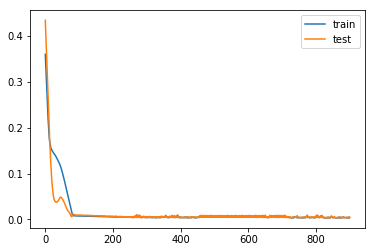

In [130]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

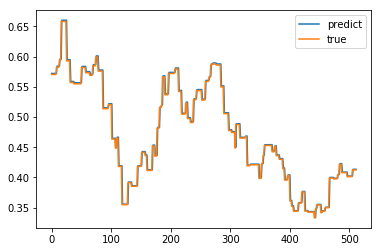

In [131]:
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [132]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

In [133]:
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 219.392


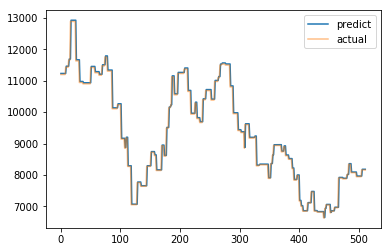

In [134]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

In [135]:
predictDates = data.tail(len(testX)).date

In [136]:
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

In [137]:
actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, actual_chart])

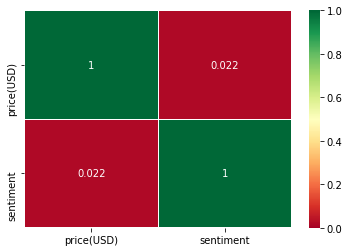

In [138]:
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)